In [5]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from ipynb.fs.full.utilities import (
    create_train_test_split
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [2]:
data_dir = 'D:/Projects/LiverSegmentation/NIfTI'
model_dir = 'D:/Projects/LiverSegmentation/Results'

In [3]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

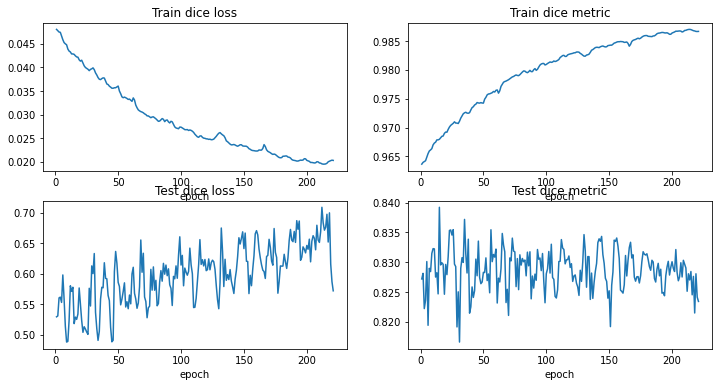

In [4]:
plt.figure("Results 24 Jan", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train dice metric")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test dice metric")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [6]:
files = create_train_test_split(data_dir, 0.2, 0)
test_files = [{'images': image_name, 'labels': label_name} for image_name, label_name in zip(files['test_images'], files['test_labels'])]
test_files = test_files[0:9]

In [8]:
test_transforms = Compose(
        [
            LoadImaged(keys=['images', 'labels']),
            AddChanneld(keys=['images', 'labels']),
            Spacingd(keys=['images', 'labels'], pixdim=(1.5, 1.5, 1.0), mode=('bilinear', 'nearest')),
            Orientationd(keys=['images', 'labels'], axcodes='RAS'),
            ScaleIntensityRanged(keys=['images'], a_min=-200, a_max=200, b_min=0, b_max=1, clip=True),
            CropForegroundd(keys=['images', 'labels'], source_key='images'),
            Resized(keys=['images', 'labels'], spatial_size=[128, 128, 64]),
            ToTensord(keys=['images', 'labels'])
        ]
    )
test_ds = Dataset(test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [9]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [11]:
checkpoint = torch.load(os.path.join(model_dir, "best_metric_model.pth"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


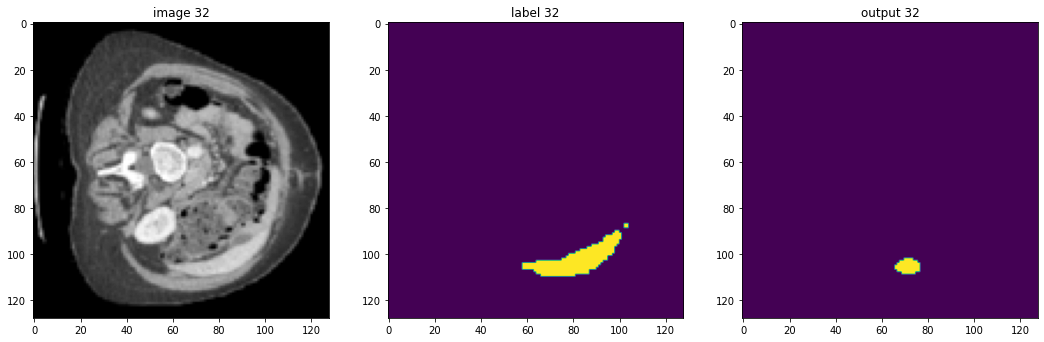

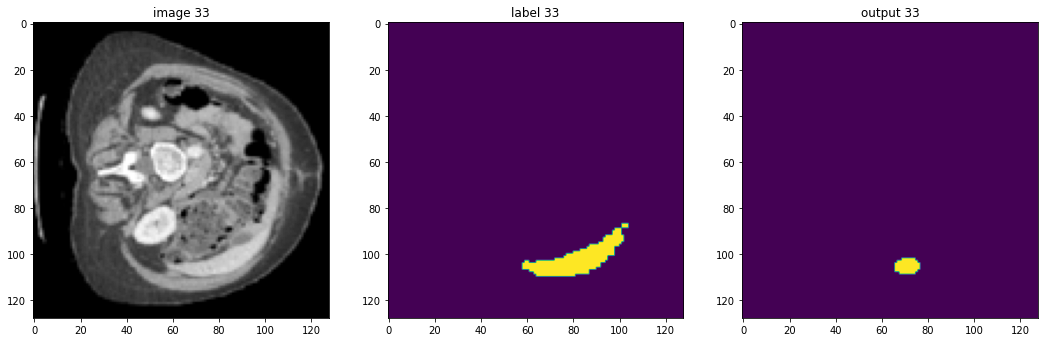

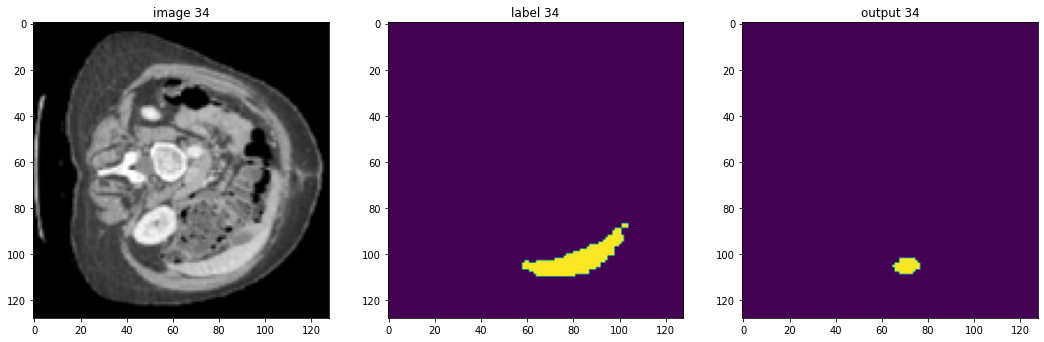

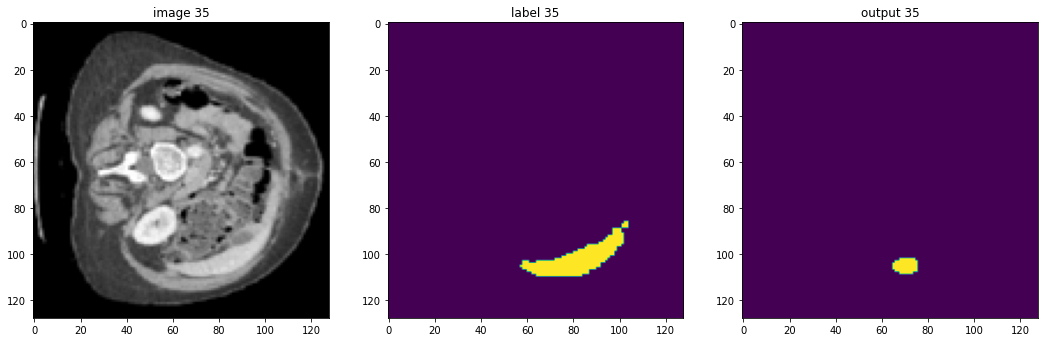

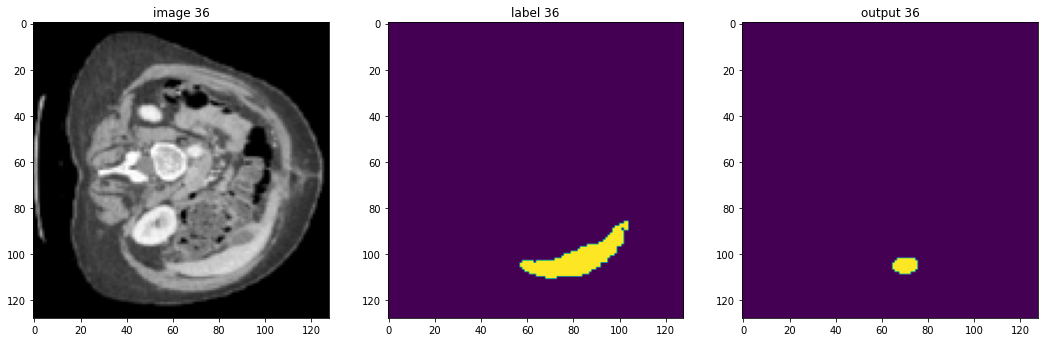

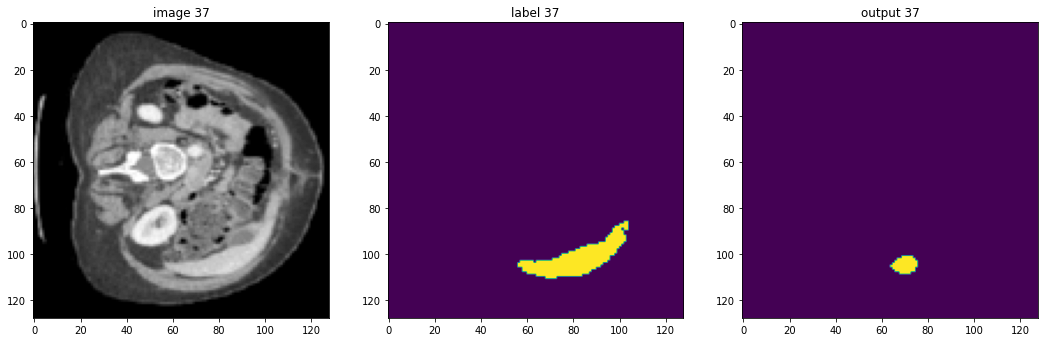

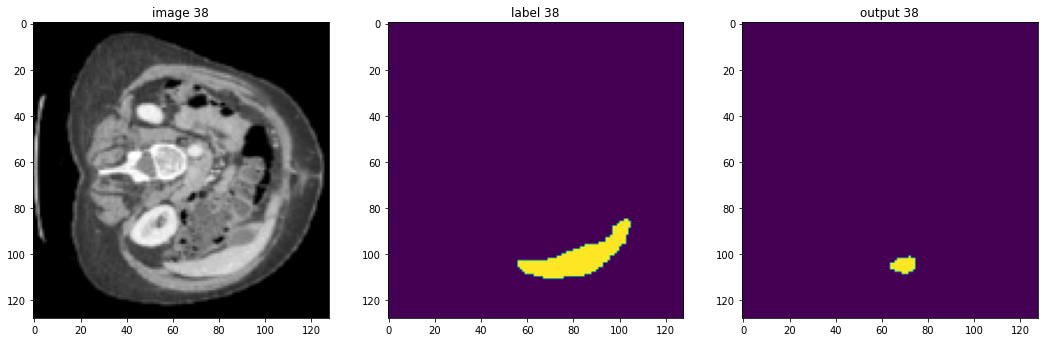

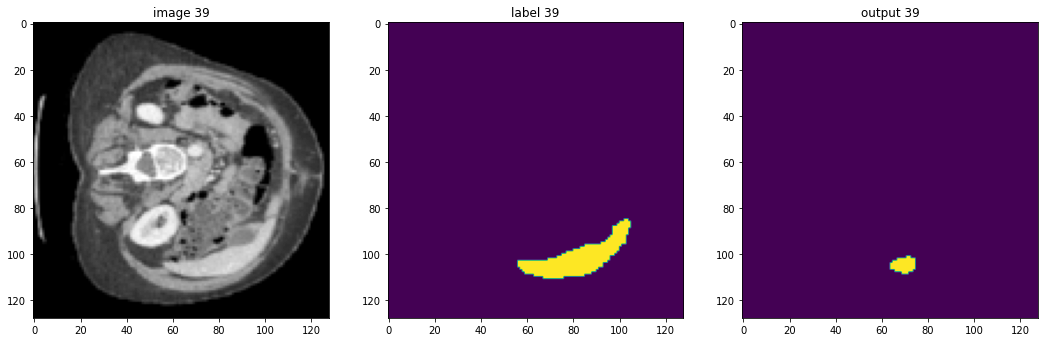

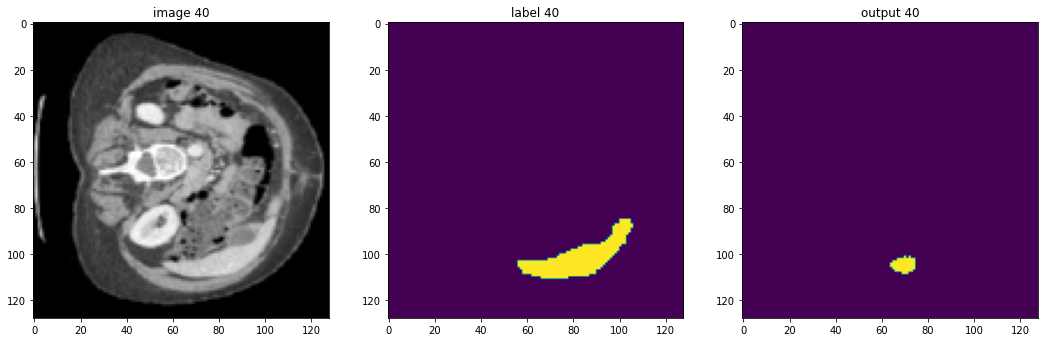

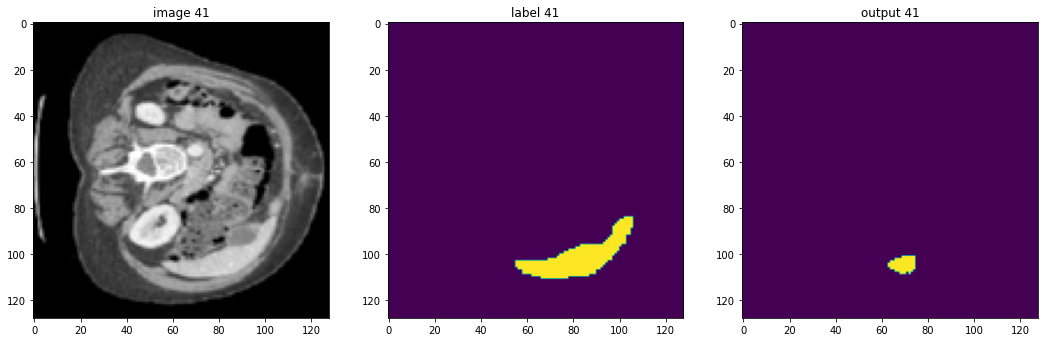

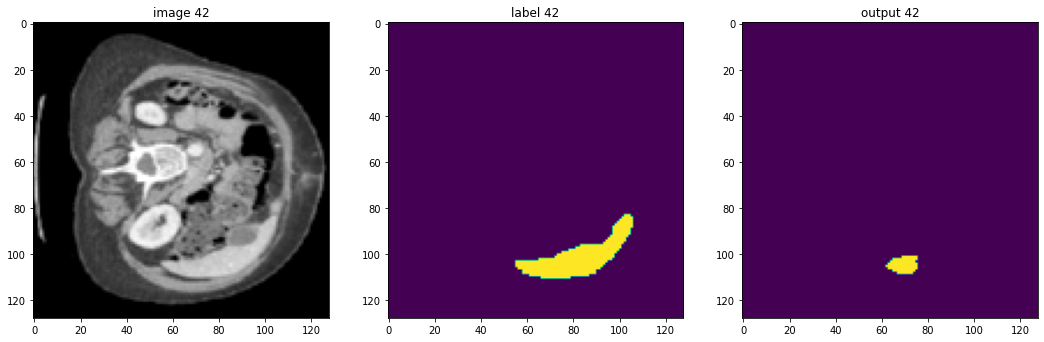

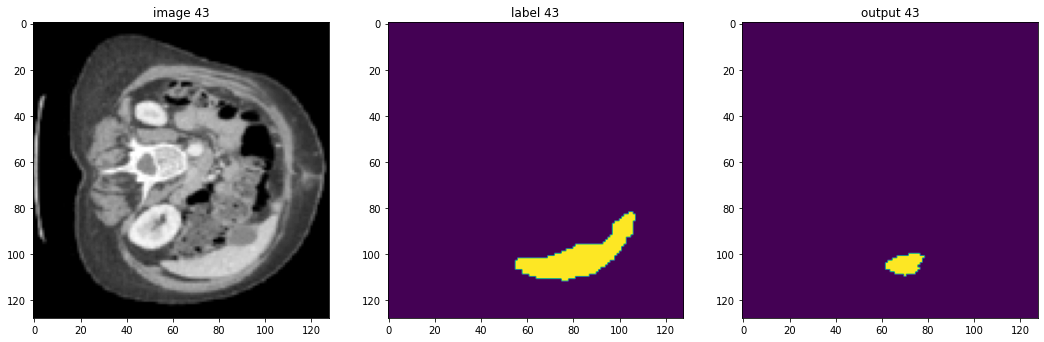

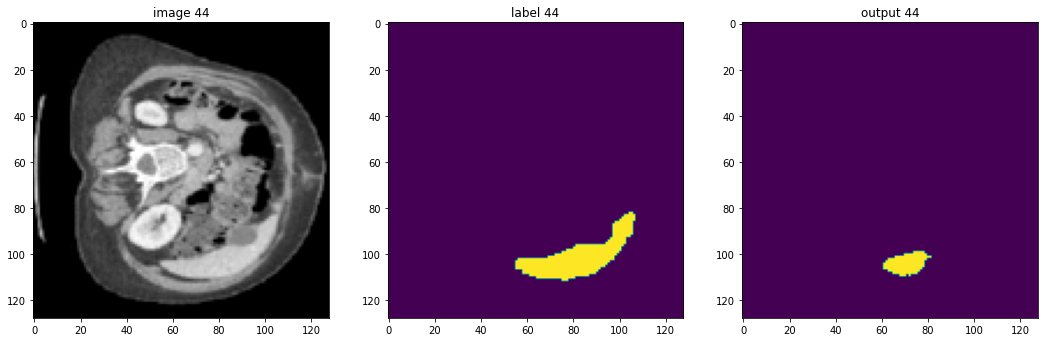

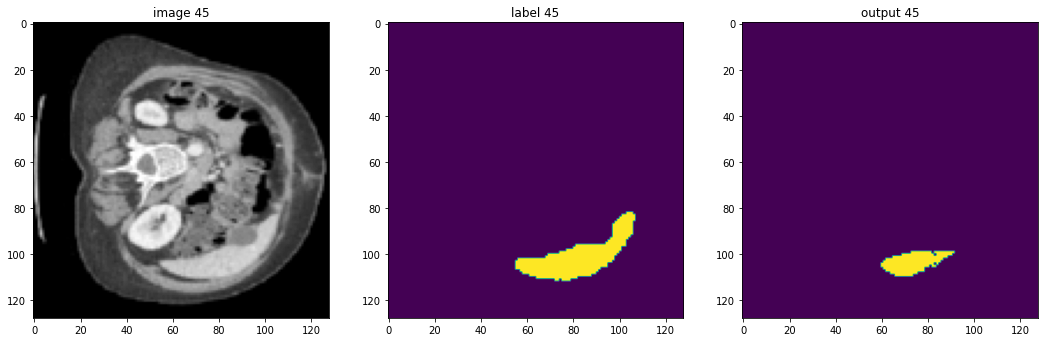

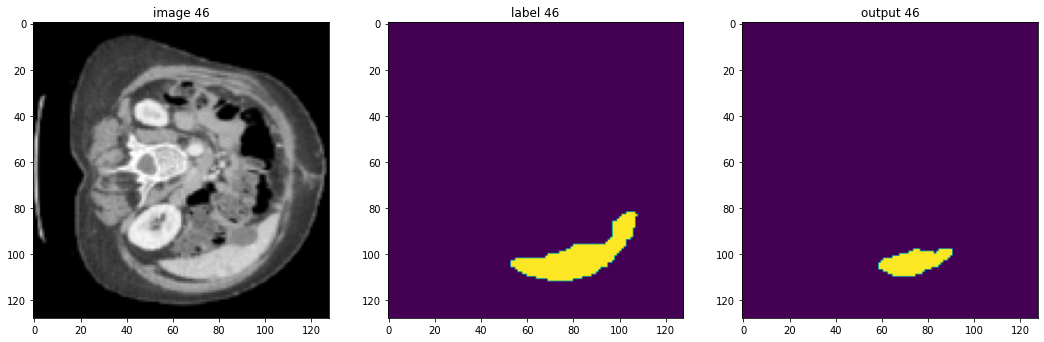

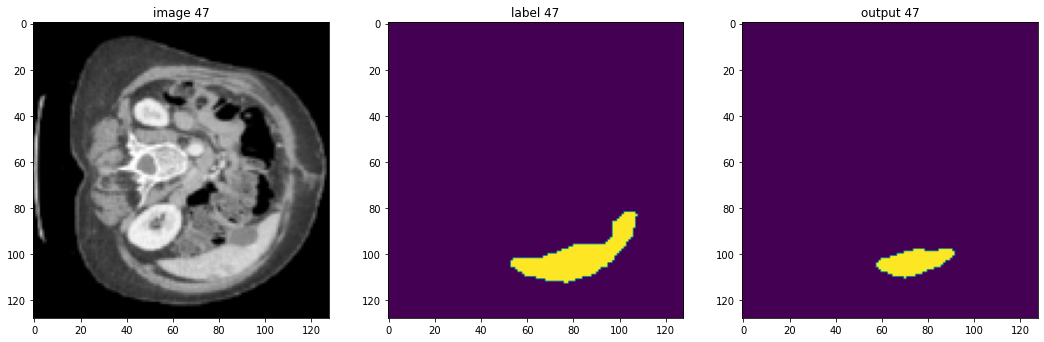

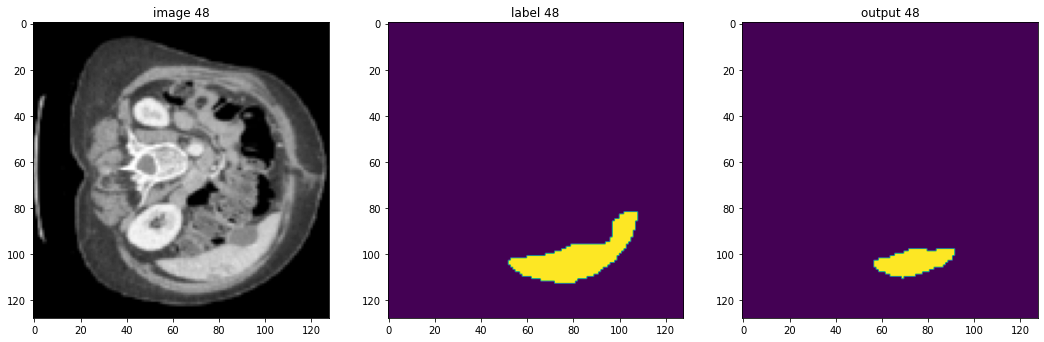

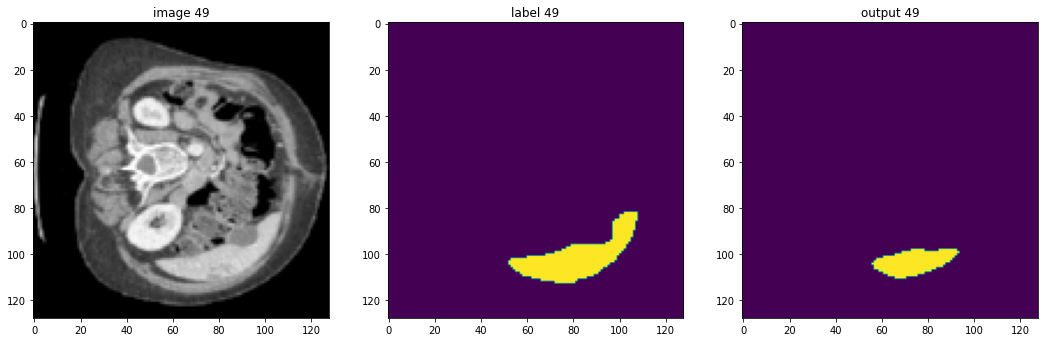

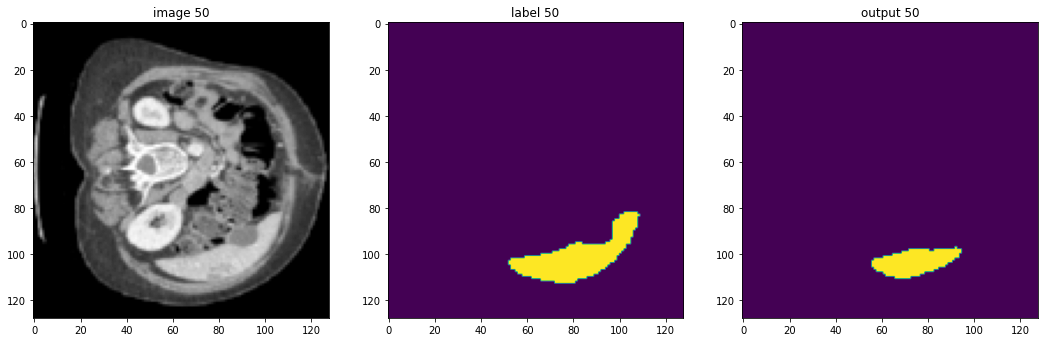

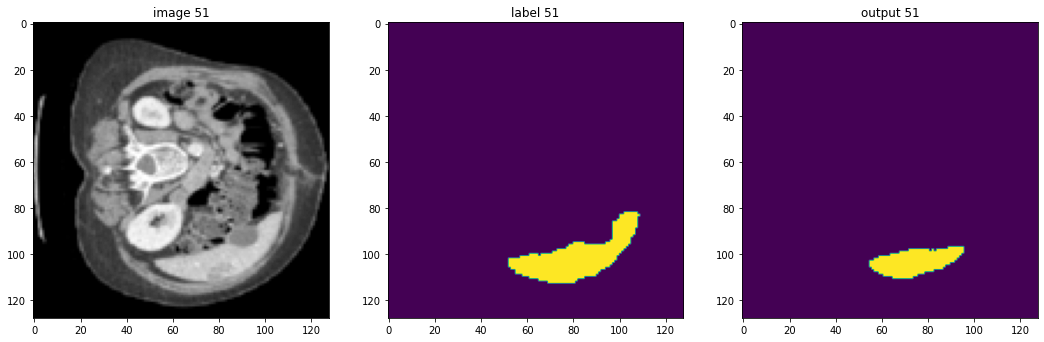

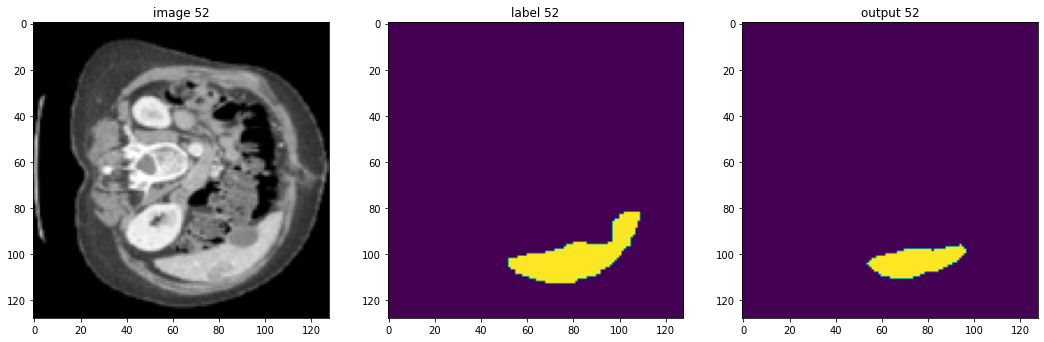

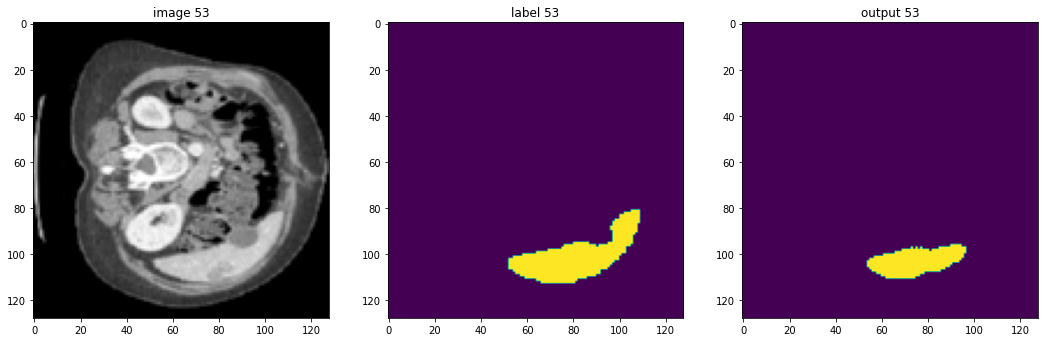

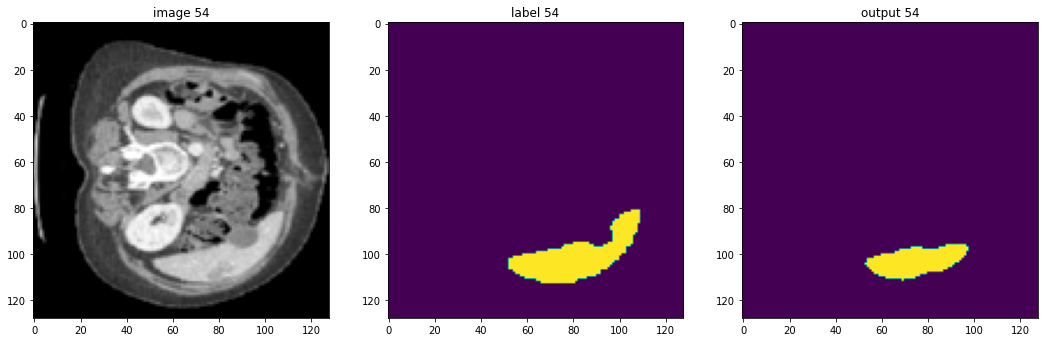

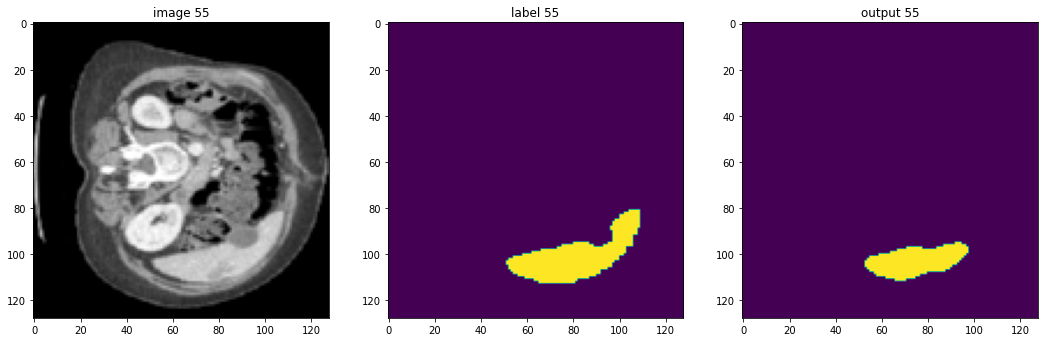

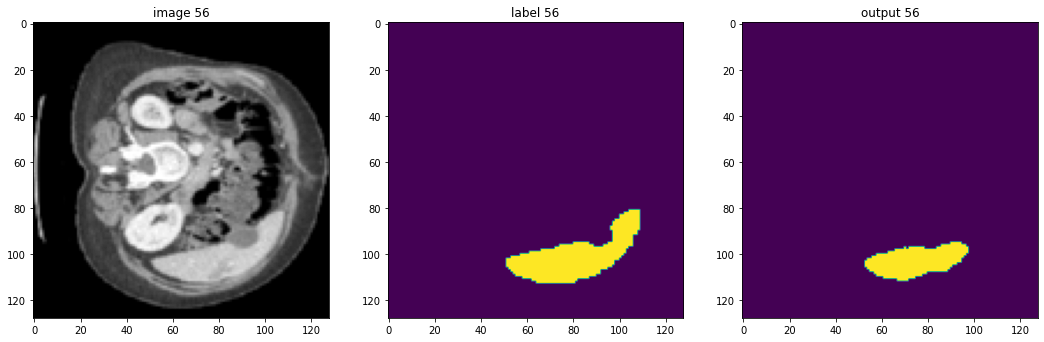

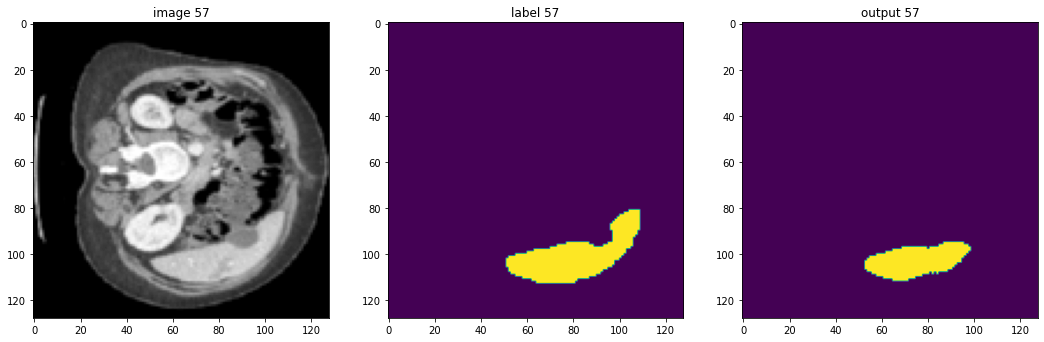

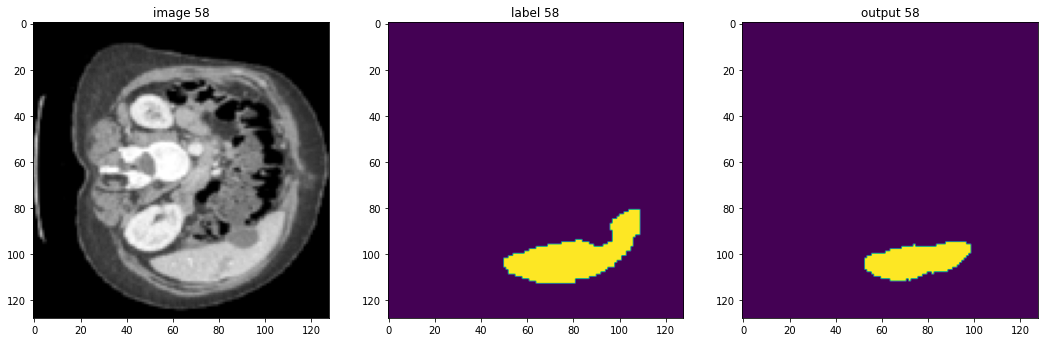

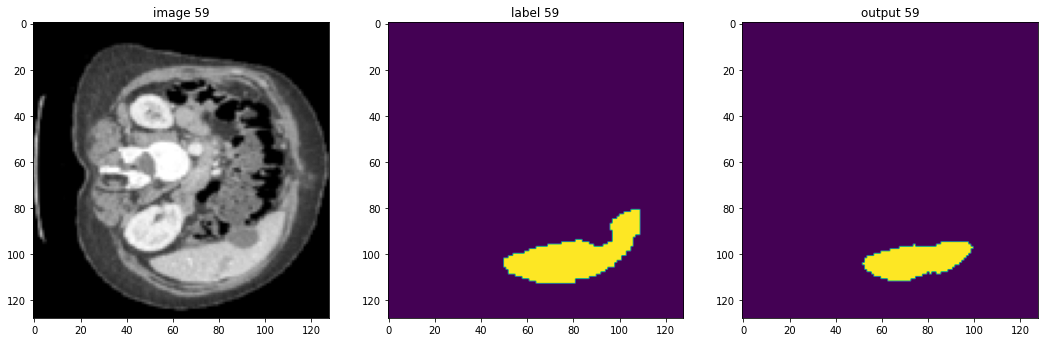

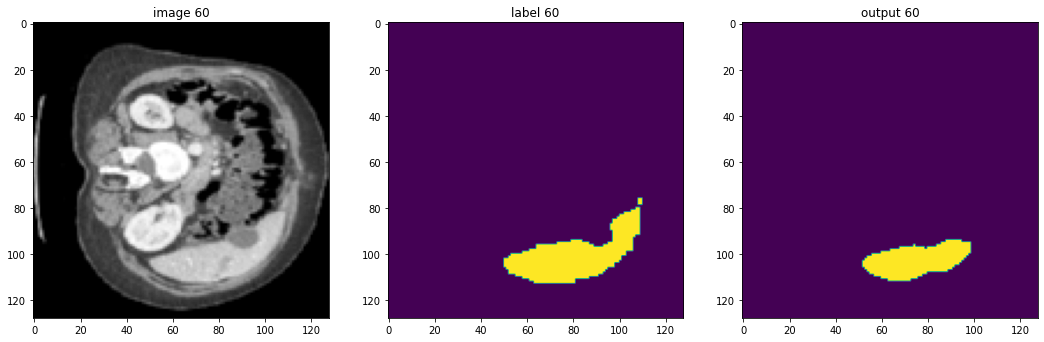

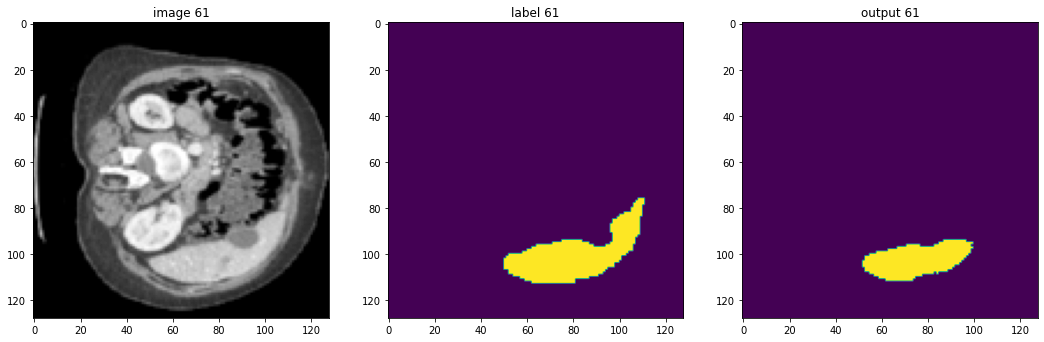

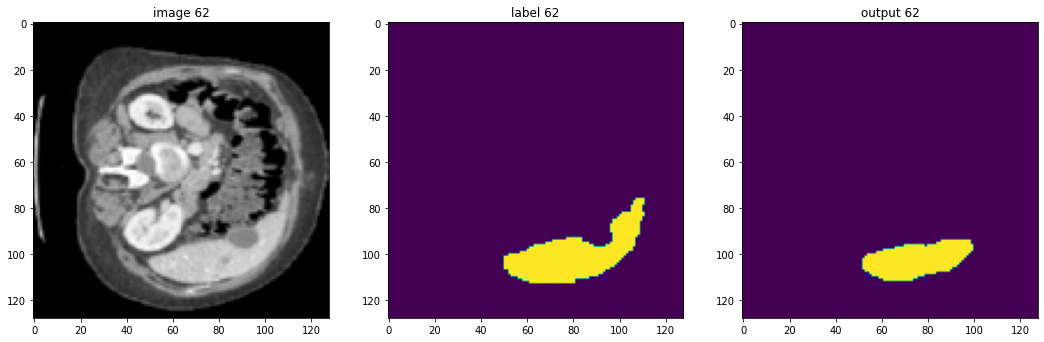

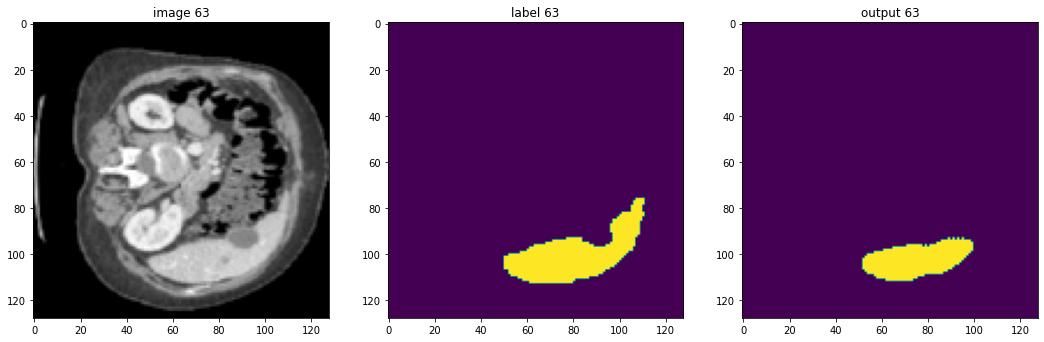

In [14]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_image = test_patient['images']
    #t_label = test_patient['labels']
    
    test_outputs = sliding_window_inference(t_image.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53
        
    for i in range(32, 64):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["images"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["labels"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()